## Lab5: Learning and Testing model

Импортируем библиотеки 

In [1]:
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple, Any

Чтение путей из csv файла

In [8]:
csv_path = "C:/Users/boris/Desktop/unik/python_university_laba/dataset/dataset.csv"
dframe = pd.read_csv(csv_path, delimiter=",", names=["Absolute path", "Relative path", "Class"])
images = dframe["Absolute path"].to_list()
print(images[0])
print(images[1])
print(images[2])


C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0000.jpg
C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0001.jpg
C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0002.jpg


Разделение данных в отношение 8 : 1 : 1

In [42]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : len(images)]

print(len(train_list), len(test_list), len(valid_list))

1608 201 202


проверка датасета

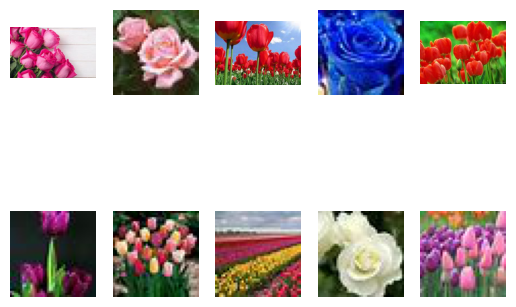

In [21]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()


Класс который будет хранить все данные изображенний

In [41]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, images, transform:Any=None) -> None:
        self.dataset = images
        self.transform = transform


    def __len__(self) -> int:
        return len(self.dataset)
    

    def __getitem__(self,index : int) -> Tuple[torch.tensor, int]:
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img = self.transform(img)
        img_label = []
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        label = img_label[index]
        if label == "rose":
            label = 0
        elif label == "tulip":
            label = 1
        return img, label
    


Предобработка данных для обучения

In [43]:
custom_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_data = dataset(train_list, transform=custom_transforms)
test_data = dataset(test_list, transform=custom_transforms)
valid_data = dataset(valid_list, transform=custom_transforms)

Проверка shape у картинки

In [44]:
train_data[0][0].shape

torch.Size([3, 224, 224])

Делаем модель сверточной нейронной сети для решения задачи классификации:

1. 3 слоя свертки и 2 полностью связанных слоя
2. пакетная нормализация для ограничения переобучения

In [45]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(576,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output
    

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = CNN()
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Рисовалка графиков

In [56]:
def draw_results(epochs, acc, loss, v_acc, v_loss) -> None:
    """Creates graphs based on the learning results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="green", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="green", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), v_loss, color="orange", label="Train loss")
    ax1.legend()
    ax2.legend()
    plt.show()

Цикл обучения модели

In [54]:
def train_loop(epochs, batch_size, lear) -> Tuple[list, CNN]:
    optimizer = optim.Adam(params=model.parameters(), lr=lear)
    criterion = nn.CrossEntropyLoss()

    accuracy_values = []
    loss_values = []
    valid_accuracy_values = []
    valid_loss_values = []
    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_data, batch_size=batch_size, shuffle=False
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, shuffle=True
    )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        print(
           f"Epoch : {epoch + 1}, train accuracy : {epoch_accuracy}, train loss : {epoch_loss}"
        )
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            print(
                f"Epoch : {epoch + 1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}"
            )
            valid_accuracy_values.append(epoch_val_accuracy.item())
            valid_loss_values.append(epoch_val_loss.item())
    draw_results(epochs, accuracy_values, loss_values, valid_accuracy_values, valid_loss_values)

9 запусков для обучения 

Epoch : 1, train accuracy : 0.7491176724433899, train loss : 0.5071666240692139
Epoch : 1, val_accuracy : 0.2133333384990692, val_loss : 1.2698190212249756
Epoch : 2, train accuracy : 0.861470639705658, train loss : 0.35098350048065186
Epoch : 2, val_accuracy : 0.33666664361953735, val_loss : 0.9902520179748535
Epoch : 3, train accuracy : 0.892058789730072, train loss : 0.28082433342933655
Epoch : 3, val_accuracy : 0.6366666555404663, val_loss : 0.9575335383415222
Epoch : 4, train accuracy : 0.8705882430076599, train loss : 0.29171448945999146
Epoch : 4, val_accuracy : 0.7000000476837158, val_loss : 0.8091961741447449
Epoch : 5, train accuracy : 0.9114704728126526, train loss : 0.24120090901851654
Epoch : 5, val_accuracy : 0.5433333516120911, val_loss : 0.9176784157752991
Epoch : 6, train accuracy : 0.9205881953239441, train loss : 0.22189858555793762
Epoch : 6, val_accuracy : 0.49000000953674316, val_loss : 1.04478919506073
Epoch : 7, train accuracy : 0.9344116449356079, train loss : 

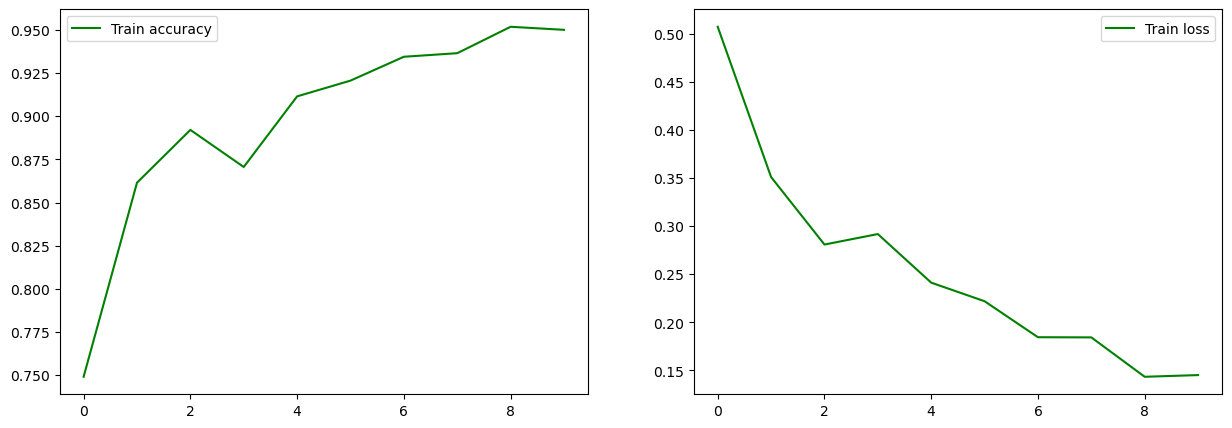

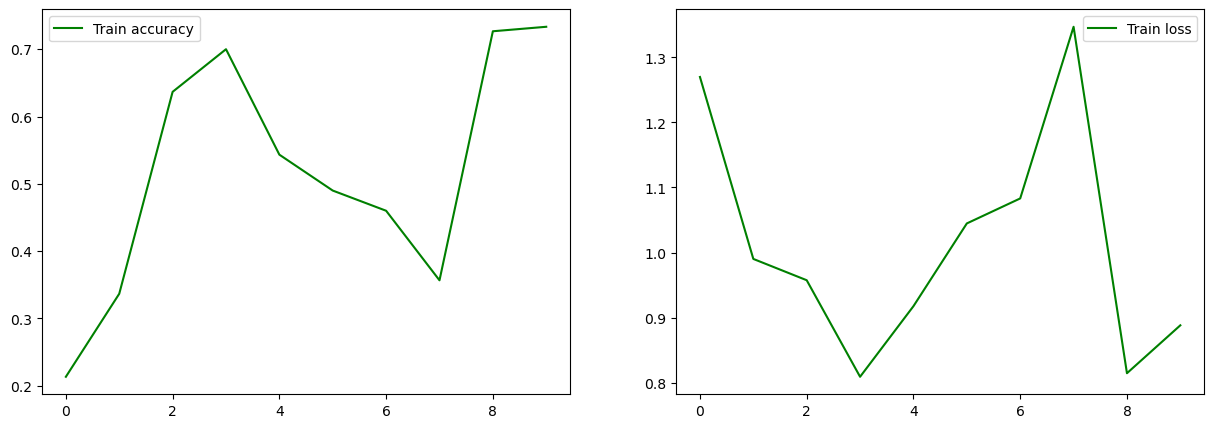

In [55]:
# ephos = 10; batch_size = 100; learning_rate = 0.001
train_loop(10, 100, 0.001)

In [ ]:
# ephos = 10; batch_size = 200; learning_rate = 0.001
train_loop(10, 200, 0.001)

In [ ]:
# ephos = 10; batch_size = 300; learning_rate = 0.001
train_loop(10, 300, 0.001)

In [ ]:
# ephos = 10; batch_size = 100; learning_rate = 0.003
train_loop(10, 100, 0.003)

In [ ]:
# ephos = 10; batch_size = 200; learning_rate = 0.003
train_loop(10, 200, 0.003)

In [ ]:
# ephos = 10; batch_size = 300; learning_rate = 0.003
train_loop(10, 300, 0.003)

In [ ]:
# ephos = 10; batch_size = 100; learning_rate = 0.006
train_loop(10, 100, 0.006)

In [ ]:
# ephos = 10; batch_size = 200; learning_rate = 0.006
train_loop(10, 200, 0.006)

In [ ]:
# ephos = 10; batch_size = 300; learning_rate = 0.006
train_loop(10, 300, 0.006)